In [1]:
# Chengzhi Dong
# ID 112890166

### Use the Bayesian clasifer to detect the ground in a greenhouse
### @Dr. Zhaozheng Yin, Stony Brook University, Fall 2021
### housekeeping
# !pip install opencv-python
import cv2
import numpy as  np
import matplotlib.pyplot as plt

In [2]:
### File directory
datadir = 'data-greenhouse/Tunnel-'   # file directory of the images
trainingImages = [2]                  # training image set
testingImages = [1, 3]                # testing image set (need to specify once again in the testing section)
### Parameters
nDim = 256 #number of bins for the color likelihood distribution. This is too big. Try to have smaller bins such as 8, 16, 32, etc.

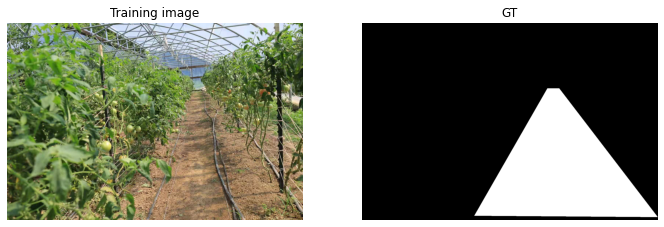

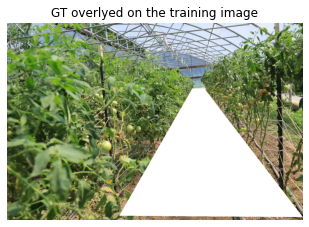

In [3]:
### Training process
Pr_x_given_y_equalsTo_1 = np.zeros((nDim,nDim,nDim)) #likelihood for the ground class
Pr_x_given_y_equalsTo_0 = np.zeros((nDim,nDim,nDim)) #likelihood for the non-ground class
N_GroundPixels = 0 #Pr_y_equalsTo_1 = N_GroundPixels/N_totalPixels
N_totalPixels = 0
for iFile in trainingImages:
    ### Load the training image and labeled image regions
    origIm = cv2.imread(datadir + '0' + str(iFile) + '.jpg')   
    labels = cv2.imread(datadir + '0' + str(iFile) + '-label.png', cv2.IMREAD_GRAYSCALE) #label=1 representing the ground class
    labels = cv2.threshold(labels, 127, 1, cv2.THRESH_BINARY)[1]
    
    ### Visualization input image and its labels
    nrows, ncols = origIm.shape[0], origIm.shape[1]
    showIm = origIm.copy() 
    showIm[labels==1] = 255;
    
    ### Be sure to convert the color space of the image from BGR (Opencv) to RGB (Matplotlib) before you show a color image read from OpenCV
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(origIm, cv2.COLOR_BGR2RGB))
    plt.title('Training image')
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(labels, 'gray')
    plt.title('GT')
    plt.axis("off")
    
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(showIm, cv2.COLOR_BGR2RGB))
    plt.title('GT overlyed on the training image')
    plt.axis("off")

    plt.show()
      
    ### Prior-related codes:
    
    N_totalPixels += (nrows * ncols) # add the pixels of this image to the total pixels of the training set
    for i in range(nrows):
        for j in range(ncols):
            if labels[i][j] == 1:
                N_GroundPixels += 1  # count the ground pixels of this image and then add to the total ground pixels of the training set
    
    ### Likelihood-related codes:
    
    for i in range(nrows):
        for j in range(ncols):
            # get the BGR values (Opencv) of each pixel of this image
            B = origIm[i][j][0]
            G = origIm[i][j][1] 
            R = origIm[i][j][2]
            
            # store in the 3-D array (255x255x255) in the order of BGR
            # count the number of pixel with certain BGR value that is ground pixel
            if labels[i][j] == 1:
                Pr_x_given_y_equalsTo_1[B][G][R] += 1
            # count the number of pixel with certain BGR value that is non-ground pixel
            else:
                Pr_x_given_y_equalsTo_0[B][G][R] += 1
                
            # value in the arrays is not probability yet
            # need to divde each of them by the number of total ground pixels or non-ground pixels
            
### Some other codes such as normalizing the likelihood/prior and computing Pr_y_equalsTo_0:

# Here I calculate the actual probability with the total data of the training set
Pr_y_equalsTo_1 = N_GroundPixels / N_totalPixels     # Pr(y=1) = ground pixels / total pixels
Pr_y_equalsTo_0 = 1 - Pr_y_equalsTo_1                # Pr(y=0) = 1 - Pr(y=1)
for i in range(nDim):
    for j in range(nDim):
        for k in range(nDim):
            # Pr(x|y=1) = the count of pixels with rbg x and y=1 / total number of ground pixels
            Pr_x_given_y_equalsTo_1[i][j][k] /= N_GroundPixels   
            # Pr(x|y=0) = the count of pixels with rbg x and y=0 / total number of non-ground pixels
            Pr_x_given_y_equalsTo_0[i][j][k] /= (N_totalPixels - N_GroundPixels)



Result Analysis for testing image 1 : 
True Positives = 68827
False Positives = 15895
False Negatives = 108135
Precision = 0.8123863931446378
Recall = 0.38893660785931444
F-score = 0.5260313966463368


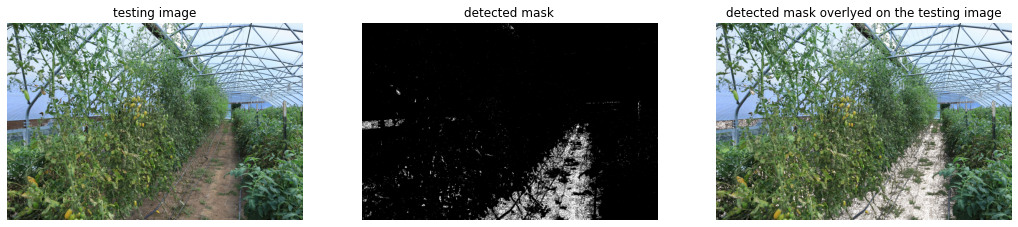

Result Analysis for testing image 3 : 
True Positives = 428110
False Positives = 54621
False Negatives = 213804
Precision = 0.8868500262050707
Recall = 0.6669273454076403
F-score = 0.7613246846782763


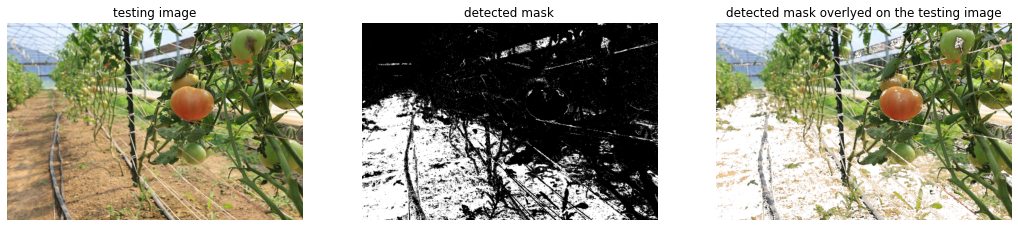

----------------------------------------
Final Result Analysis:
Total true positives = 496937
Total false positives = 70516
Total false negatives = 321939
Overall precision = 0.8757324395148145
Overall recall = 0.606852563758127
Micro F-score = 0.7169106323246502
Macro F-score = 0.6436780406623066


In [4]:
### Testing
truePositives = 0;    # total true positives of the testing set
falsePositives = 0;   # total false positives of the testing set
falseNegatives = 0;   # total false negatives of the testing set
micro_precision = 0   # micro precision of all images in the testing set
micro_recall = 0      # micro recall of all images in the testing set
micro_fscore = 0      # micro fscore of the test result
macro_fscore = 0      # macro fscore of the test result
image_count = 0       # number of image in the testing set
testingImages = [1, 3]     # testing image set
for iFile in testingImages:  
    ### Load the testing image and ground truth regions  
    origIm = cv2.imread(datadir + '0' + str(iFile) + '.jpg')
    gtMask = cv2.imread(datadir + '0' + str(iFile) + '-label.png', cv2.IMREAD_GRAYSCALE)
    gtMask = cv2.threshold(gtMask, 127, 1, cv2.THRESH_BINARY)[1]
    nrows, ncols = origIm.shape[0], origIm.shape[1] 
    
    ### Define the posteriors
    Pr_y_equalsTo_1_given_x = np.zeros((nrows,ncols));   
    Pr_y_equalsTo_0_given_x = np.zeros((nrows,ncols));

    ### Codes to infer the posterior:
    
    # for each pixel of the testing image, calculate the posteriors: Pr(y=1|x) and Pr(y=0|x)
    # using only likelihood * prior: Pr(x|y=1)Pr(y=1) and Pr(x|y=0)Pr(y=0)
    # when comparing the two posteriors the evidences Pr(x) cancels each other out
    # therefore, the evidence Pr(x) is unnecessary in this case 
    for i in range(nrows):
        for j in range(ncols):
            B = origIm[i][j][0]
            G = origIm[i][j][1]
            R = origIm[i][j][2]
            Pr_y_equalsTo_1_given_x[i][j] = (Pr_x_given_y_equalsTo_1[B][G][R] * Pr_y_equalsTo_1)
            Pr_y_equalsTo_0_given_x[i][j] = (Pr_x_given_y_equalsTo_0[B][G][R] * Pr_y_equalsTo_0)
            
    
    ### Codes to obtain the final classification result (detectedMask):
    
    # create a nrows * ncols array for detected Mask
    # 0 for non-ground pixels; 1 for ground pixels
    detectedMask = np.zeros((nrows,ncols))
    for i in range(nrows):
        for j in range(ncols):
            # if Pr(y=1|x) is greater than Pr(y=0|x) for that BGR value, then consider it as ground pixel
            # not using greater than or equals to in comparsion because there is limited trainning data
            # some pixels has BGR value that never appear in the trainning image
            # so Pr(y=1|x) and Pr(y=0|x) are both zeros for these BGR values
            if Pr_y_equalsTo_1_given_x[i][j] > Pr_y_equalsTo_0_given_x[i][j]:
                detectedMask[i][j] = 1
    
    
    ### Codes to calculate the TP, FP, FN:
    
    TP = 0     # true positives of current image
    FP = 0     # false positives of current image
    FN = 0     # false negaitves of current image
    image_count += 1     # increase number count of images in testing set by 1
    
    # for each pixels in the Detected Mask and Ground Truth Mask
    for i in range(nrows):
        for j in range(ncols):
            # if both shows it is a ground pixels, it counts as a true positive
            if gtMask[i][j] == 1 and detectedMask[i][j] == 1:
                TP += 1
                truePositives += 1
            # if detected a ground pixel but the ground truth is non-ground, it counts as a false positive
            elif gtMask[i][j] == 0 and detectedMask[i][j] == 1:
                FP += 1
                falsePositives += 1
            # if detected a non-ground pixel but the ground truth is ground, it counts as a false negative
            elif gtMask[i][j] == 1 and detectedMask[i][j] == 0:
                FN += 1
                falseNegatives += 1
    
    # calculate precision, recall, and fscore for current image
    current_precision = TP / (TP + FP)
    current_recall = TP / (TP + FN)
    current_fscore = (2 * current_precision * current_recall) / (current_precision + current_recall)
    macro_fscore += current_fscore
    
    print("Result Analysis for testing image " + str(iFile) + " : ")
    print("True Positives = " + str(TP))
    print("False Positives = " + str(FP))
    print("False Negatives = " + str(FN))
    print("Precision = " + str(current_precision))
    print("Recall = " + str(current_recall))
    print("F-score = " + str(current_fscore))
    
    
    
    ### Visualize the classification results
    showIm = origIm.copy()
    showIm[detectedMask==1] = 255;

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(origIm, cv2.COLOR_BGR2RGB))
    plt.title('testing image')
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(detectedMask, 'gray')
    plt.title('detected mask')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(showIm, cv2.COLOR_BGR2RGB))
    plt.title('detected mask overlyed on the testing image')
    plt.axis("off")
    plt.show()

### Codes to calculate the precision, recall, and fscore:

print("----------------------------------------")
print("Final Result Analysis:")
micro_precision = truePositives / (truePositives + falsePositives)
micro_recall = truePositives / (truePositives + falseNegatives)
micro_fscore = (2 * micro_precision * micro_recall) / (micro_precision + micro_recall)
macro_fscore = macro_fscore / image_count
print("Total true positives = " + str(truePositives))
print("Total false positives = " + str(falsePositives))
print("Total false negatives = " + str(falseNegatives))
print("Overall precision = " + str(micro_precision))
print("Overall recall = " + str(micro_recall))
print("Micro F-score = " + str(micro_fscore))
print("Macro F-score = " + str(macro_fscore))
